In [1]:
import os

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image

In [2]:
csv_file = 'data/full_emoji.csv'
data = pd.read_csv(csv_file)
data.sample(n=5)

,#,emoji,unicode,name,Apple,Google,Facebook,Windows,Twitter,JoyPixels,Samsung,Gmail,SoftBank,DoCoMo,KDDI
1698,1699,🇲🇨,U+1F1F2 U+1F1E8,flag: Monaco,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,NaN,NaN,NaN
1709,1710,🇲🇵,U+1F1F2 U+1F1F5,flag: Northern Mariana Islands,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,NaN,NaN,NaN
719,720,🍙,U+1F359,rice ball,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPALMPAEpKSv7+...","data:image/png;base64,R0lGODlhDwAPAHcAMSH+GlNv...","data:image/png;base64,R0lGODlhDAAMAIABAAAAAP//...","data:image/png;base64,R0lGODlhDgAPAKIGAJmZmTMz..."
1170,1171,📽,U+1F4FD,film projector,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...",NaN,NaN,NaN,NaN
1248,1249,📏,U+1F4CF,straight ruler,"data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAA...","data:image/png;base64,R0lGODlhDwAPALMPAFpxqV+V...",NaN,NaN,"data:image/png;base64,R0lGODlhDgAPAKIEAJnM////..."


In [3]:
def get_label_for_row(df: pd.DataFrame, idx:int) -> int:
    return 1 if 'face' in df.loc[idx, "name"].lower() else 0

print(get_label_for_row(data, 12))
print(get_label_for_row(data, 1208))

1
0


In [4]:
class EmojiDataset(Dataset):
    def __init__(self, img_dirs, csv_file, transform=None):
        self.img_dirs = img_dirs
        self.data = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id = self.data.iloc[idx, 0]
        for img_dir in self.img_dirs:
            img_path = os.path.join(img_dir, f'{img_id}.png')
            if os.path.exists(img_path):
                break
        else:
            raise FileNotFoundError(f'Image with ID {img_id} not found in any of the specified directories.')

        label = get_label_for_row(self.data, idx)
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

img_dirs = [
    'data/image/Apple',
    'data/image/DoCoMo',
    'data/image/Facebook',
    'data/image/Gmail',
    'data/image/Google',
    'data/image/JoyPixels',
    'data/image/KDDI',
    'data/image/Samsung',
    'data/image/SoftBank',
    'data/image/Twitter',
    'data/image/Windows'
]
csv_file = 'data/full_emoji.csv'
dataset = EmojiDataset(img_dirs, csv_file, transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, 1024, 4, 1, 0, bias=False),  # Output: (1024, 4, 4)
            nn.BatchNorm2d(1024),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(1024, 512, 4, 2, 1, bias=False),  # Output: (512, 8, 8)
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),  # Output: (256, 16, 16)
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),  # Output: (128, 32, 32)
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),   # Output: (64, 64, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 3, 1, 1, bias=False),     # Output: (3, 64, 64)
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Conv2d(512, 1024, 4, 2, 1, bias=False),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3)
        )
        self.fc = nn.Linear(1024 * 2 * 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input):
        x = self.main(input)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.sigmoid(x)
        return x

In [7]:
nz = 256  # Size of z latent vector (i.e. size of generator input)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

fixed_noise = torch.randn(64, nz, 1, 1, device=device)

netG = Generator(nz).to(device)
netD = Discriminator().to(device)
criterion = nn.BCELoss()

cuda


In [8]:
from torch.autograd import Variable, grad

# Custom weight initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Apply the weight initialization to the generator and discriminator
netG.apply(weights_init)
netD.apply(weights_init)

# Function to compute gradient penalty for Discriminator
def compute_gradient_penalty(D, real_samples, fake_samples):
    alpha = torch.randn((real_samples.size(0), 1, 1, 1), device=device)
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = Variable(torch.ones(real_samples.size(0), 1).to(device), requires_grad=False)
    gradients = grad(outputs=d_interpolates, inputs=interpolates,
                     grad_outputs=fake, create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

# Hyperparameters
lrD = 0.00001
lrG = 0.00025
lambda_gp = 2.5  # Gradient penalty coefficient

# Define optimizers
optimizerD = optim.AdamW(netD.parameters(), lr=lrD, betas=(0.5, 0.999))
optimizerG = optim.AdamW(netG.parameters(), lr=lrG, betas=(0.5, 0.999))

Epoch [9/250]
	Loss D Real:	0.8357757329940796
	Loss D Fake:	0.10176167637109756
	Loss D Total:	0.9375374093651772
	Loss G:	0.7631679177284241
	Loss Total:	1.7007053270936012


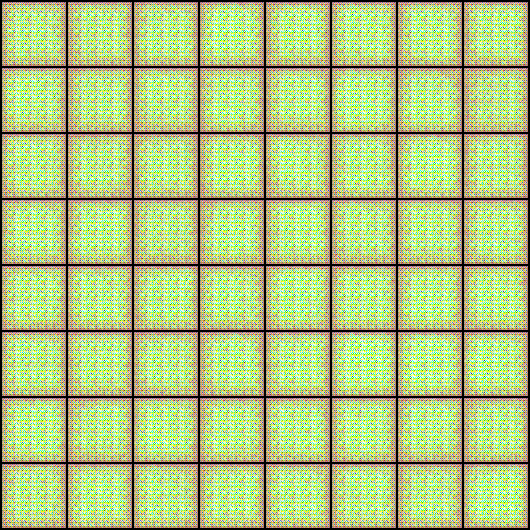

In [ ]:
from IPython.display import clear_output, display

num_epochs = 250

for epoch in range(num_epochs):
    lossD_real = -1
    lossD_fake = -1
    lossG = -1
    for i, data in enumerate(dataloader, 0):
        real_images, real_labels = data
        real_images = real_images.to(device)

        batch_size = real_images.size(0)
        
        # Label Smoothing for real images.
        real_labels = ((real_labels + 0.01) * 0.99).unsqueeze(1).to(device)
        fake_labels = torch.full((batch_size,), 0.01, dtype=torch.float, device=device).unsqueeze(1)
        
        # Train Discriminator with real images
        netD.zero_grad()
        output_real = netD(real_images)
        lossD_real = criterion(output_real, real_labels)
        
        # Train Discriminator with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_images = netG(noise)
        output_fake = netD(fake_images.detach())
        lossD_fake = criterion(output_fake, fake_labels)
        
        # Compute gradient penalty
        gradient_penalty = compute_gradient_penalty(netD, real_images.data, fake_images.data)
        lossD = lossD_real + lossD_fake + gradient_penalty
        lossD.backward()
        
        optimizerD.step()
        
        # Train Generator
        netG.zero_grad()
        output_fake = netD(fake_images)
        lossG = criterion(output_fake, real_labels)
        lossG.backward()
        
        optimizerG.step()
    
    # Save generated images for impactful display.
    with torch.no_grad():
        fake_images = netG(fixed_noise).detach().cpu()
        
    clear_output()
    print(f'Epoch [{epoch}/{num_epochs}]\n\t'
                  f'Loss D Real:\t{lossD_real.item()}\n\t'
                  f'Loss D Fake:\t{lossD_fake.item()}\n\t'
                  f'Loss D Total:\t{lossD_real.item() + lossD_fake.item()}\n\t'
                  f'Loss G:\t{lossG.item()}\n\t'
                  f'Loss Total:\t{lossD_real.item() + lossD_fake.item() + lossG.item()}')
    img_epoch = (epoch+1) if (epoch+1) % 5 == 0 else "latest"
    save_image(fake_images, f'artifact/generated/epoch_{img_epoch}.png', normalize=True)
    display(Image.open(f'artifact/generated/epoch_{img_epoch}.png'))